### Classification of pH range using machine learning

In [1]:
#libs
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
import pandas as pd
import numpy as np
import scikitplot as skplt
import matplotlib.pyplot as plt
from sklearn import metrics

from sklearn.pipeline import Pipeline
from sklearn import preprocessing as pp
import seaborn as sns

In [2]:
# load data
acidoCEST_ML = pd.read_parquet('../clean_data/acido_CEST_MRI_Iopamidol.parquet.gzip')

# drop columns we cannot measure or that are redundant
cols_2_drop = ['ApproT1(sec)','Temp','ExpB0(ppm)','FILE','Conc(mM)']
acidoCEST_ML = acidoCEST_ML.drop(cols_2_drop, axis = 1)

In [3]:
# define experimental columns -- > things we measure other than CEST
exper_cols = [ 'ExpB1(percent)', 'ExpB0(Hz)', 'SatPower(uT)',  'SatTime(ms)','ExpT1(ms)', 'ExpT2(ms)']

In [4]:
# used during development
#acidoCEST_ML  = acidoCEST_ML.sample( n = 1_000)

In [5]:
acidoCEST_ML.shape

(20000, 88)

In [6]:
# Regression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestRegressor as RFR

def train_RFR(Xdata, pH_observed):
    print('------------------ Random Forest ------------------ ')
    print()
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(Xdata, pH_observed, test_size=0.30, random_state=42)
        
        
    
    max_f = int( 0.5 * Xdata.shape[1] )
        
    # Regression
    #param_grid = dict( n_estimators = [100,200,500], max_depth =[None], max_features=['sqrt','log2','auto',max_f], max_samples=[.10,.50], min_samples_leaf=[.01,.50] )

    
    param_grid = dict( n_estimators = [100,200,500], max_depth =[10,20,40,None] )

    
    # grid parameters
    scorer = metrics.make_scorer( metrics.r2_score, greater_is_better = True) 
    
    #
    estimator = GridSearchCV( RFR(random_state = 42, criterion = 'mae', n_jobs = -1), param_grid, verbose = 3, cv = 3, n_jobs= 1, scoring=scorer )

    # fit
    estimator.fit(X_train, y_train)

    score_train = np.round( 100 * metrics.mean_absolute_percentage_error(y_train , estimator.predict(X_train)), 2)
    score_test  = np.round( 100 * metrics.mean_absolute_percentage_error(y_test , estimator.predict(X_test)), 2)



    m = f' mean absolute percentage error \n train = {score_train} % \n test  = {score_test} %'
    
    #print(', '.join(Xdata.columns.to_list()))
    print()
    print(m)
   
    plt.figure()
    sns.regplot(x = estimator.best_estimator_.predict(X_train), y =  y_train)
    plt.xlabel('\n Predicted pH')
    plt.ylabel('Measured pH \n')
    plt.title('Train Random Forest')
    
    plt.figure()
    sns.regplot(x = estimator.best_estimator_.predict(X_test), y =  y_test)
    plt.xlabel('\n Predicted pH')
    plt.ylabel('Measured pH \n')
    plt.title('Test Random Forest')
    
    print(estimator.best_estimator_)
    
    return estimator.best_estimator_
    
    
def train_lasso(Xdata, pH_observed):
    print('------------------ LASSO ------------------ ')
    print()
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(Xdata, pH_observed, test_size=0.30, random_state=42)
    
    # LASSO
    lasso = linear_model.Lasso( max_iter = 5000, random_state=42)

    #pipeline
    pipe = Pipeline(steps=[('Scaler', pp.StandardScaler()), ('lasso', lasso)])

    param_grid ={
            'lasso__alpha': np.linspace(.01,1,20),
            'lasso__fit_intercept': [True,False]
            }

    scorer = metrics.make_scorer( metrics.mean_absolute_percentage_error, greater_is_better=False) 


    estimator = GridSearchCV(pipe, param_grid, verbose = 0, cv = 3, n_jobs= 6, scoring=scorer )


    # fit
    estimator.fit(X_train, y_train)

    score_train = np.round( 100 * metrics.mean_absolute_percentage_error(y_train , estimator.predict(X_train)), 2)
    score_test  = np.round( 100 * metrics.mean_absolute_percentage_error(y_test , estimator.predict(X_test)), 2)

    m = f' mean absolute percentage error \n train = {score_train} % \n test  = {score_test} %'
    
  
    #print(', '.join(Xdata.columns.to_list()))
    print()
    print(m)

    
    plt.figure()
    sns.regplot(x = estimator.best_estimator_.predict(X_train), y =  y_train)
    plt.xlabel('\n Predicted pH')
    plt.ylabel('Measured pH \n')
    plt.title('Train LASSO')
    
    plt.figure()
    sns.regplot(x = estimator.best_estimator_.predict(X_test), y =  y_test)
    plt.xlabel('\n Predicted pH')
    plt.ylabel('Measured pH \n')
    plt.title('Test LASSO')
    
    return estimator.best_estimator_

## 4.2 and 5.6 only

------------------ LASSO ------------------ 


 mean absolute percentage error 
 train = 3.99 % 
 test  = 4.01 %


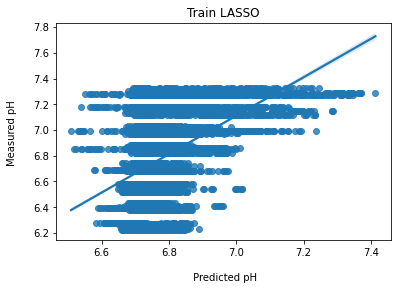

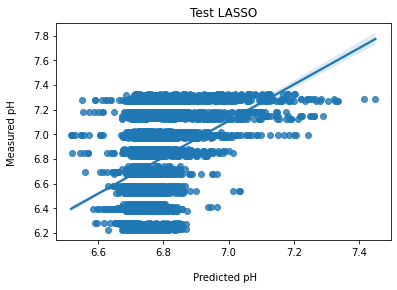

In [7]:
X = acidoCEST_ML[['4.2','5.6']]
Y = acidoCEST_ML.pH
reg_lr = train_lasso(X,Y)

------------------ Random Forest ------------------ 

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV 1/3] END ....max_depth=10, n_estimators=100;, score=0.232 total time=   9.5s
[CV 2/3] END ....max_depth=10, n_estimators=100;, score=0.218 total time=  10.2s
[CV 3/3] END ....max_depth=10, n_estimators=100;, score=0.225 total time=  10.0s
[CV 1/3] END ....max_depth=10, n_estimators=200;, score=0.232 total time=  18.5s
[CV 2/3] END ....max_depth=10, n_estimators=200;, score=0.219 total time=  18.7s
[CV 3/3] END ....max_depth=10, n_estimators=200;, score=0.226 total time=  18.5s
[CV 1/3] END ....max_depth=10, n_estimators=500;, score=0.233 total time=  45.4s
[CV 2/3] END ....max_depth=10, n_estimators=500;, score=0.219 total time=  50.3s
[CV 3/3] END ....max_depth=10, n_estimators=500;, score=0.226 total time=  49.0s
[CV 1/3] END ....max_depth=20, n_estimators=100;, score=0.165 total time=   9.9s
[CV 2/3] END ....max_depth=20, n_estimators=100;, score=0.160 total time=  

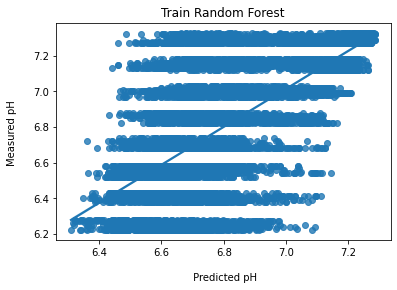

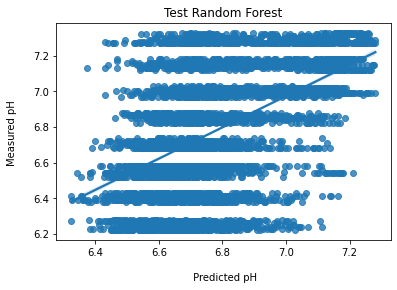

In [8]:
reg_rf = train_RFR(X,Y)

## 4.2 ppm, 5.6 ppm, exp data

------------------ LASSO ------------------ 


 mean absolute percentage error 
 train = 3.85 % 
 test  = 3.91 %


Pipeline(steps=[('Scaler', StandardScaler()),
                ('lasso', Lasso(alpha=0.01, max_iter=5000, random_state=42))])

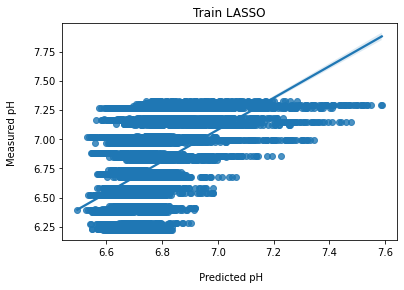

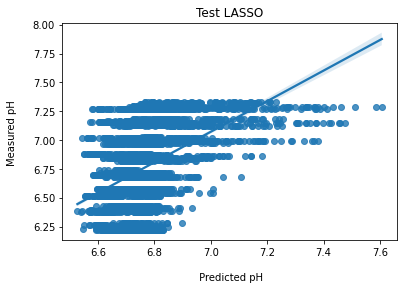

In [9]:
len(['4.2','5.6'] + exper_cols)
c = ['4.2','5.6'] + exper_cols
X = acidoCEST_ML[c]
Y = acidoCEST_ML.pH
train_lasso(X,Y)

------------------ Random Forest ------------------ 

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV 1/3] END ....max_depth=10, n_estimators=100;, score=0.797 total time=  20.5s
[CV 2/3] END ....max_depth=10, n_estimators=100;, score=0.776 total time=  21.1s
[CV 3/3] END ....max_depth=10, n_estimators=100;, score=0.811 total time=  20.8s
[CV 1/3] END ....max_depth=10, n_estimators=200;, score=0.798 total time=  38.4s
[CV 2/3] END ....max_depth=10, n_estimators=200;, score=0.777 total time=  43.5s
[CV 3/3] END ....max_depth=10, n_estimators=200;, score=0.811 total time=  40.4s
[CV 1/3] END ....max_depth=10, n_estimators=500;, score=0.796 total time= 1.6min
[CV 2/3] END ....max_depth=10, n_estimators=500;, score=0.779 total time= 1.7min
[CV 3/3] END ....max_depth=10, n_estimators=500;, score=0.810 total time= 1.6min
[CV 1/3] END ....max_depth=20, n_estimators=100;, score=0.975 total time=  20.0s
[CV 2/3] END ....max_depth=20, n_estimators=100;, score=0.973 total time=  

RandomForestRegressor(criterion='mae', n_estimators=500, n_jobs=-1,
                      random_state=42)

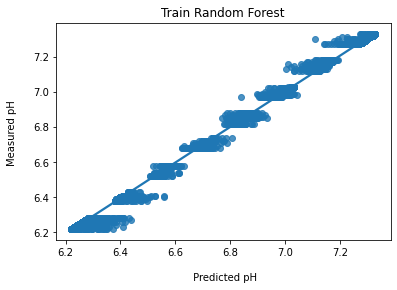

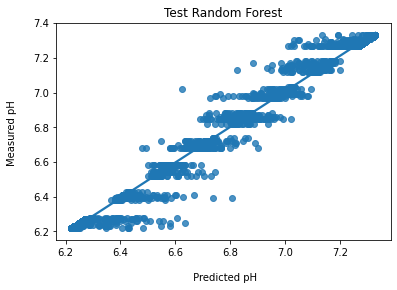

In [10]:
train_RFR(X,Y)

# - Only Zspectra

------------------ LASSO ------------------ 


 mean absolute percentage error 
 train = 3.56 % 
 test  = 3.59 %


Pipeline(steps=[('Scaler', StandardScaler()),
                ('lasso', Lasso(alpha=0.01, max_iter=5000, random_state=42))])

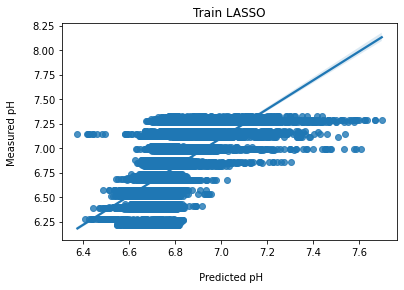

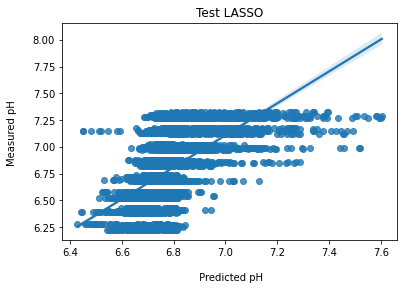

In [11]:
Xdata = acidoCEST_ML.drop(exper_cols + ['pH'],axis=1)
Ydata = acidoCEST_ML.pH 

train_lasso(Xdata,Ydata)

In [ ]:
train_RFR(Xdata,Ydata)

------------------ Random Forest ------------------ 

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV 1/3] END ....max_depth=10, n_estimators=100;, score=0.607 total time= 5.8min
[CV 2/3] END ....max_depth=10, n_estimators=100;, score=0.604 total time= 6.3min
[CV 3/3] END ....max_depth=10, n_estimators=100;, score=0.607 total time= 6.1min
[CV 1/3] END ....max_depth=10, n_estimators=200;, score=0.608 total time=14.8min


# -  Zspectra  + exp data
## selected

In [ ]:
Xdata = acidoCEST_ML.drop( ['pH'],axis=1) 
Ydata = acidoCEST_ML.pH

lasso = train_lasso(Xdata,Ydata)

lasso['lasso']

In [ ]:
RF    = train_RFR(Xdata,Ydata)

## LASSO COEFF

In [ ]:
reg_lasso = lasso['lasso']

C = pd.DataFrame( reg_lasso.coef_ , columns=['Lasso Coeff'], index = Xdata.columns)
_, ax = plt.subplots(dpi = 100)

C[reg_lasso.coef_ != 0].plot(kind='bar', ax = ax)
plt.title('Non-zero Lasso Coefficients \n')
plt.xlabel('\n Feature')
plt.ylabel('Value \n')



In [ ]:
list(C[reg_lasso.coef_ != 0].index)

## Random Forest, Feature Importance

In [ ]:
I = pd.DataFrame( 100 * RF.feature_importances_, columns=['Importance'], index = Xdata.columns)
_, ax = plt.subplots(dpi = 100, figsize=(16,6))

I.sort_values('Importance').plot(kind='bar', ax = ax, rot=90)

## Feature Selection

In [ ]:
from sklearn.feature_selection import SelectFromModel

In [ ]:
selected_lasso = SelectFromModel( reg_lasso, max_features=20) 
selected_lasso.fit(Xdata, Ydata)
Xdata.columns[selected_lasso.get_support()]

In [ ]:
selected_RF = SelectFromModel( RF  , max_features=20) 
selected_RF.fit(Xdata, Ydata)
cols = Xdata.columns[selected_RF.get_support()]
print(cols)

In [ ]:
RF_sel    = train_RFR(Xdata[cols],Ydata)

## Tree Vis

In [ ]:
n_features = []

for i,tree in enumerate( RF.estimators_):
    ft = list( Xdata.columns[ tree.feature_importances_ != 0  ]  )
    n = len(Xdata.columns[ tree.feature_importances_ != 0  ])
    n_non_CEST = sum(['(' in x for x in ft])
    print(f' tree = {i+1} | {n - n_non_CEST} saturation frequencies | {n_non_CEST} non-CEST | total = {n}')
    n_features.append(n)

In [ ]:
%%capture
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree


idx = np.argmin(n_features)-1
tree= RF.estimators_[idx]

#classes = list( pd.Series(tree.classes_).replace([0,1],[' pH < 7', 'pH > 7']).values )

fig = plt.figure(dpi=500)
plot_tree( tree,  feature_names = Xdata.columns,
          filled=True, impurity=False,  max_depth = 4, fontsize = 4, label='none', proportion =True,
          rounded=False);

plt.savefig(f'../figs/Tree_example_max_depth_04_tree{idx}_regression.png',bbox_inches='tight')

In [ ]:
from sklearn.tree import export_text

tree_as_text = export_text( tree
                  ,  max_depth = 4
                  ,  decimals = 3
                  ,  spacing = 3
                  , feature_names = list( Xdata.columns  )
                  , show_weights=True )   

In [ ]:
print(tree_as_text)